The goal of this notebook is to replicate the paper: __https://arxiv.org/abs/2010.11929__

In [43]:
import torch
import torchvision

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] couldn't find torchinfo... installing...")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    print(f"[INFO] could't find going_modular scripts... downloading...")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

In [44]:
# setting up device agnostic code
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
device

'cpu'

## Getting Data Ready

In [45]:
from pathlib import Path

data_path = Path("going_modular/data/")
image_path = data_path / "pizza_steak_sushi"
                 
# setting directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/pizza_steak_sushi/train'),
 PosixPath('going_modular/data/pizza_steak_sushi/test'))

In [46]:
from torchvision import transforms
from going_modular import data_setup

# image size = 224x224 as it's the same size ViT was trained on 
IMG_SIZE = 224 # refer table 3 of the ViT paper
BATCH_SIZE = 32 # in paper teh batch size use was 4096 but we don't have that much data so using batch_size of 32

# creating transform
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=data_transform,
                                                                              batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

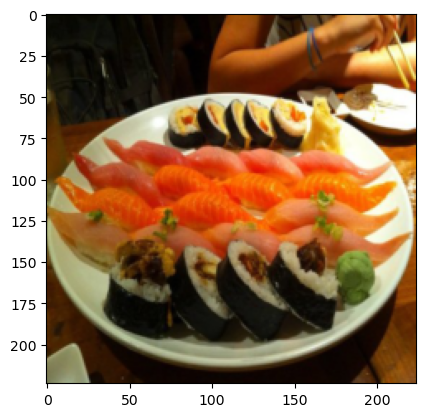

In [47]:
# visualizing a single image to check we got the correct dataloaders
from matplotlib import pyplot as plt

img, label = next(iter(train_dataloader)) # this gives first batch
plt.imshow(img[0].permute(1, 2, 0)) # fist image from that batch

## Replicating Vision Transformer (ViT)

#### Architecture

![](architecture.png)

#### Mathematical Equations
![](equations.png)

__Equation 1:__ <br>
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

```python
x_input = [class_token, image_patch_1, image_patch_2, ..., image_patch_N] + 
          [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..., image_patch_2_pos]
```

__Equation 2 & Equation 3:__ <br>
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded self- attention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). <br>


```python
# equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

__Equation 4:__ <br>
Similar to BERT's [{class}] token, we prepend a learnable embedding to the sequence of embedded patches ($\mathbf{z}_0^0 = \mathbf{x}_\text{class}$), whose state at the output of the Transformer encoder ($\mathbf{z}_L^0$) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

```python
y = Linear_layer(LN_layer(x_output_MLP_block))
```

## Equation 1

__Convert Images Into Patches__

In [48]:
height = 224
width = 224
color_channels = 3
patch_size = 16

# calc number of patches
num_of_patches = (height * width) // (patch_size**2)

# input shape
embedding_layer_input_shape = (height, width, color_channels)
# output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f"Input Shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output Shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape (single 2D image): (224, 224, 3)
Output Shape (single 1D sequence of patches): (196, 768)


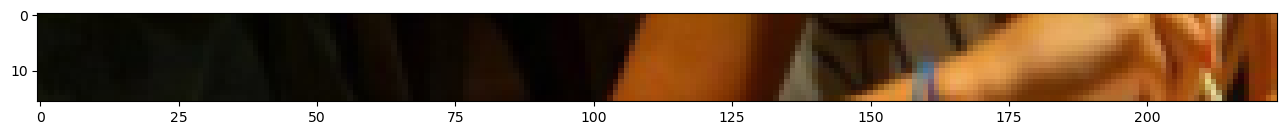

In [49]:
# patches row wise
image_permuted = img[0].permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

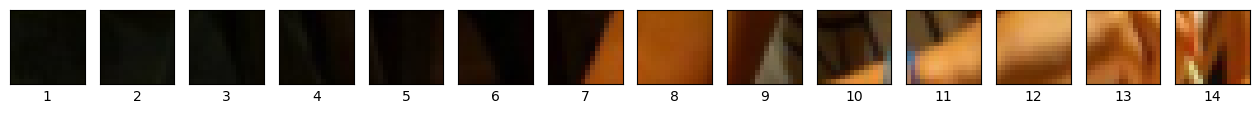

In [50]:
# creating pathces columnwise
img_size = 224
patch_size = 16
num_patches = img_size // patch_size

assert img_size % patch_size == 0

# create a series of subpolots
fig, axs = plt.subplots(nrows=1,
                        ncols= num_patches,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

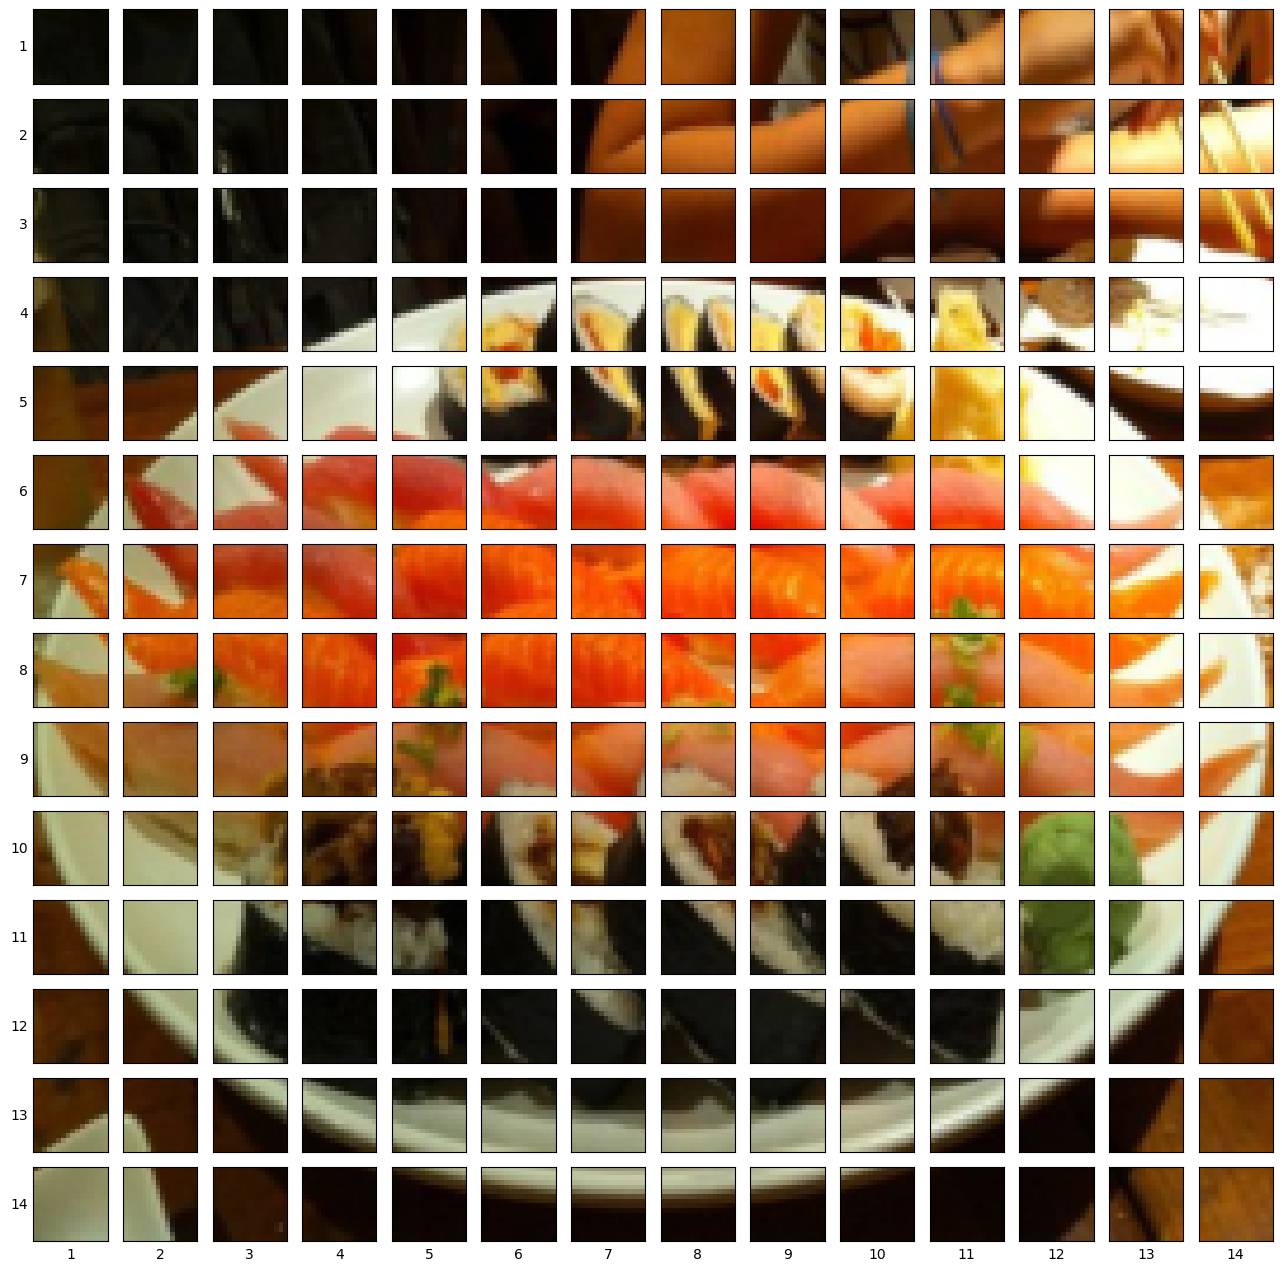

In [51]:
# creating patches rowwise and also columnwise
img_size = 224
patch_size = 16
num_patches = img_size // patch_size

assert img_size % patch_size == 0

# create a grid of subplots
fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, row_patch in enumerate(range(0, img_size, patch_size)):
    for j, col_patch in enumerate(range(0, img_size, patch_size)):
        axs[i][j].imshow(image_permuted[patch_size*i:patch_size*(i+1), 
                                        patch_size*j:patch_size*(j+1), :])
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])   
        axs[i][j].set_ylabel(i+1, 
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i][j].set_xlabel(j+1)
        axs[i][j].label_outer()

__Convert patches to embeddings__ <br>
We can convert pathces to embeddings with conv2d layers. We have to set the kernel_size to path_size so that each patch get multiplied with a single kernel and also we can keep the stride to patch_size so that after multiplying one patch the kernel moves to the next patch.

In [52]:
from torch import nn

# set the patch_size
patch_size = 16

# creating a Conv2d layer
conv2d = nn.Conv2d(in_channels=3, # color channels 
                   out_channels=768, # D size (embedding size from Table 1)
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

# pass the image through the conv layer
image_out_of_conv = conv2d(img[0].unsqueeze(0)) # adds batch dimension
print(f"Output Shape: {image_out_of_conv.shape} -> batch_size, num_patches, feature_map_height, feature_map_width")

Output Shape: torch.Size([1, 768, 14, 14]) -> batch_size, num_patches, feature_map_height, feature_map_width


Showing random convolutional feature maps from indexes: [520, 190, 707, 514, 519]


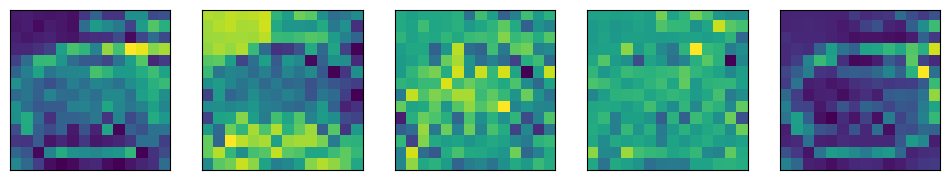

In [53]:
# plot random convolution feature map (embeddings)
import random 
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index to output tensor of conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dim, and remove grad tracking to switch to numpy
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

__Flattening the patch embeddings with `torch.nn.Flatten()`__ <br>
Right now we've a series of convolutional feature maps (batch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.

In [54]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

# what we get after passing the image throgh the flatten layer
flatten_layer(image_out_of_conv).shape # batch_size, embeddings, num_patches

torch.Size([1, 768, 196])

In [55]:
# we want the embedding matrix to be batch_size x num_patches x embeddings
flatten_output = flatten_layer(image_out_of_conv)
print(f"Flatten Layer Output: {flatten_output.shape}")
permute_dimensions = flatten_output.permute(0, 2, 1)
print(f"Permuted Dimension: {permute_dimensions.shape}")

Flatten Layer Output: torch.Size([1, 768, 196])
Permuted Dimension: torch.Size([1, 196, 768])


In [56]:
# get a single flattened feature map 
singel_flattened_feature_map = permute_dimensions[:, :, 0]
singel_flattened_feature_map

tensor([[-0.0259, -0.0458, -0.0309, -0.0257, -0.0185, -0.0604, -0.1114, -0.5265,
         -0.2236, -0.3135, -0.7324, -0.5899, -0.5206, -0.5030, -0.0234, -0.0352,
         -0.0558, -0.0450, -0.0335, -0.0015, -0.3273, -0.5345, -0.5761, -0.4462,
         -0.2771, -0.6264, -1.0157, -1.3488, -0.1086, -0.0276, -0.0603, -0.0809,
         -0.0656, -0.0184, -0.1857, -0.2168, -0.2046, -0.1719, -0.1862, -0.2767,
         -0.4732, -0.6245, -0.1826, -0.0801, -0.0837, -0.4639, -0.8614, -1.0146,
         -0.9518, -0.9320, -1.1281, -1.3518, -1.1412, -0.9030, -1.3574, -1.3609,
         -0.2860, -0.3486, -0.8916, -1.1761, -0.7117, -0.2678, -0.2010, -0.2028,
         -0.2504, -0.5631, -0.9406, -1.1930, -0.4716, -0.3865, -0.3766, -0.7244,
         -0.6905, -0.5153, -0.5816, -0.8284, -0.7442, -0.8797, -0.9460, -1.0227,
         -0.9416, -1.2590, -1.1498, -0.9631, -0.6343, -0.6132, -0.6055, -0.5838,
         -0.5282, -0.6209, -0.7234, -0.7423, -0.7850, -0.7987, -0.6922, -0.9110,
         -0.8072, -1.1215, -

(-0.5, 195.5, 0.5, -0.5)

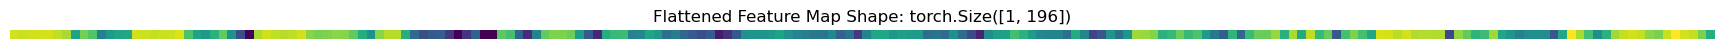

In [57]:
# plot this single_feature_map
plt.figure(figsize=(22,22))
plt.imshow(singel_flattened_feature_map.detach().numpy())
plt.title(f"Flattened Feature Map Shape: {singel_flattened_feature_map.shape}")
plt.axis(False)

In [58]:
# doing all these with a single block of layers

from torch import nn

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size):
        super().__init__()
        self.conv2d = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0
        
                 )
        self.flatten = nn.Flatten(start_dim=2,
                             end_dim=3)
        
    def forward(self, x):
        x = self.flatten(self.conv2d(x))
        return x.permute(0, 2, 1)

In [59]:
# lets try this PatchEmbedding Class
patchify = PatchEmbedding(in_channels=3, embedding_dim=768, patch_size=16)

print(f"Original Batch Shape: {img.shape}")
embedding = patchify(img)
print(f"Embedded Batch Shape: {embedding.shape}")

Original Batch Shape: torch.Size([32, 3, 224, 224])
Embedded Batch Shape: torch.Size([32, 196, 768])


__Creating Class Token Embedding__ <br>
We want to prepend a learnable class token to the start of the patch embedding. <br>
So the new output will be of the shape [32, 197, 768]

In [60]:
# create class token embedding as a learnable parameter that shares same size as embedding dim
batch_size = embedding.shape[0]
embedding_dim = embedding.shape[2]

# here we are using torch.ones so that the output become visible and easy to verify
# while in the true training process we will use torch.randn()
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True) # so that the it becomes learnable

# now we just have to append the class token to out embedding matrix
tokens_with_embedding = torch.cat((class_token, embedding), dim=1)

# checking the shape 
print(f"After Concatenation: {tokens_with_embedding.shape}")
print(tokens_with_embedding[0]) # first row of the batch is full of ones

After Concatenation: torch.Size([32, 197, 768])
tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.0186, -0.0083,  0.0241,  ..., -0.0288,  0.0240,  0.0274],
        [ 0.0190, -0.0261,  0.0296,  ..., -0.0341,  0.0257,  0.0337],
        ...,
        [ 0.0748, -0.0595,  0.0059,  ..., -0.0764, -0.0074,  0.0746],
        [ 0.1383, -0.0718,  0.0452,  ..., -0.2546,  0.0519,  0.0442],
        [ 0.0165, -0.2081,  0.1334,  ..., -0.2837,  0.0518, -0.0602]],
       grad_fn=<SelectBackward0>)


__Creating Positional Embeddings__ <br>
Now we want the the positional matrix of the same size of [32 x 197 x 768]. So that we add the positional embedding matrix to the tokens_with_embedding matrix.

In [61]:
# calculate N (number of patches)
num_of_patches = int((height * width) / patch_size**2)

# get the embedding dim
embedding_dim = tokens_with_embedding.shape[-1]

# create positional embedding
position_embedding = nn.Parameter(torch.ones(1, num_of_patches+1, embedding_dim),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [62]:
# now we just have to add the 2 embedding matrix as both are of the same shape
# here just adding to the fist batch but in training time will have to add to all the batches
token_positional_embedding = tokens_with_embedding[0] + position_embedding

token_positional_embedding, token_positional_embedding.shape

(tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
          [1.0186, 0.9917, 1.0241,  ..., 0.9712, 1.0240, 1.0274],
          [1.0190, 0.9739, 1.0296,  ..., 0.9659, 1.0257, 1.0337],
          ...,
          [1.0748, 0.9405, 1.0059,  ..., 0.9236, 0.9926, 1.0746],
          [1.1383, 0.9282, 1.0452,  ..., 0.7454, 1.0519, 1.0442],
          [1.0165, 0.7919, 1.1334,  ..., 0.7163, 1.0518, 0.9398]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

__Putting Everything All Together For Equation 1__

In [63]:
# set hyper parameters
patch_size = 16
batch_size = img.shape[0]
height, width = img[0].shape[1], img[0].shape[2]
color_channels = img[0].shape[0]
embedding_dim = patch_size * patch_size * color_channels
num_patches = height * width // patch_size**2

# printing the original image size
print(f"Image Tensor Image: {img[0].shape}")

# creating Patch_Embedding class instance
patchify = PatchEmbedding(in_channels=color_channels,
                          embedding_dim=embedding_dim,
                          patch_size=patch_size)

# creating patch embedding 
patch_embedding = patchify(img)

# after patchifying printing the dimension
print(f"Patched Embedding: {patch_embedding.shape}")

# making class token learnable
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dim),
                            requires_grad=True)

# prepend class tokens to the patch_embedding
token_patch_embedding = torch.cat((class_token, patch_embedding), dim=1)

# print shape after prepending 
print(f"Token Patch Embedding: {token_patch_embedding.shape}")

# creating learnable postional embeddings 
positional_embedding = nn.Parameter(torch.randn(batch_size, num_patches+1, embedding_dim),
                                     requires_grad=True)

# adding the positional_embeddings to the token_patch_embedding
positional_token_patch_embedding = token_patch_embedding + positional_embedding

# printing final input shape
print(f"Positional Token Patch Embedding: {positional_token_patch_embedding.shape}")

Image Tensor Image: torch.Size([3, 224, 224])
Patched Embedding: torch.Size([32, 196, 768])
Token Patch Embedding: torch.Size([32, 197, 768])
Positional Token Patch Embedding: torch.Size([32, 197, 768])


## Equation 2

__Creating MultiHead Self Attention__ <br>
__MutltiHeadAttention: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html__ <br>
__Layer Norm: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html__

In [64]:
from torch import nn

class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [65]:
msa_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12, dropout=0)

attn_output = msa_block(positional_token_patch_embedding)

attn_output.shape

torch.Size([32, 197, 768])

## Equation 3

In the paper it is mentioned that the MLP contains 2 layers with GELU non linearity. <br>
Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.

In [66]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1): # all values come from paper
        super().__init__()
        
        # create a norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # create MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
        
    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [67]:
# lets see if we get any errors
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

image_through_mlp_block = mlp_block(attn_output)

image_through_mlp_block.shape

torch.Size([32, 197, 768])

__Putting Eq 2 & Eq 3 together to build Encoder__

In [68]:
class Encoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, attn_dropout=0, mlp_size=3072, mlp_dropout=0.1):
        super().__init__()
        
        # creating msa block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embed_dim, 
                                                     num_heads=num_heads, 
                                                     dropout=attn_dropout)
        
        # creating mlp block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embed_dim, 
                                  mlp_size=mlp_size, 
                                  dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection
        x = self.mlp_block(x) + x # residual/skip connection
        return x

In [69]:
# creating an instance of the Encoder class
encoder = Encoder()

# getting the summary of the model
summary(model=encoder,
        input_size=(32, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=16,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape      Output Shape     Param #          Trainable
Encoder (Encoder)                                  [32, 197, 768]   [32, 197, 768]   --               True
├─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]   [32, 197, 768]   --               True
│    └─LayerNorm (layer_norm)                      [32, 197, 768]   [32, 197, 768]   1,536            True
│    └─MultiheadAttention (multihead_attn)         --               [32, 197, 768]   2,362,368        True
├─MLPBlock (mlp_block)                             [32, 197, 768]   [32, 197, 768]   --               True
│    └─LayerNorm (layer_norm)                      [32, 197, 768]   [32, 197, 768]   1,536            True
│    └─Sequential (mlp)                            [32, 197, 768]   [32, 197, 768]   --               True
│    │    └─Linear (0)                             [32, 197, 768]   [32, 197, 3072]  2,362,368        True
│    │    └─GELU (1)            

Pytorch have inbuilt Transformer Layers so we can also make one with inbuil PyTorch layers. <br>
__Transformer: https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html__ <br>
__TransformerEncoder: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html__ <br>
__TransformerEncoderLayer: https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer__

In [70]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True) # first we apply norm and then pass it further
                                                                        # as in ViT paper

summary(model=transformer_encoder_layer,
        input_size=(32, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=16,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape      Output Shape     Param #          Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [32, 197, 768]   [32, 197, 768]   7,087,872        True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 19.37
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 19.37

## ViT Architecture

In [71]:
# create ViT class
from torch import nn

class ViT(nn.Module):
    def __init__(self, 
                 img_size: int=224, # Table 3 from ViT paper
                 color_channels: int=3, 
                 patch_size: int=16,
                 num_transformer_layer: int=12, # Table1 for "Layers" for ViT-Base,
                 embedding_dim: int=768, # hidden size D from Table 1 for ViT-Base
                 mlp_size: int=3072, # Table 1
                 num_heads: int=12, # Table 1
                 attn_dropout: int=0, 
                 mlp_dropout: int=0.1,
                 embedding_dropout: int=0.1, # dropout for patch and position embeddings
                 num_classes: int=1000): # num of classes in our problem
        super().__init__()
        
        # making an assertion that img_size is compatible with patch_size
        assert img_size%patch_size==0, f"Image Size Must Be Divisible By Patch Size, img_size:{img_size}, patch_size:{patch_size}"
        
        self.height, self.width = img_size, img_size
        self.patch_size = patch_size
        self.num_patches = (self.height * self.width) // (self.patch_size**2)
        
        # creating PatchEmbeding Class instance
        self.patchify = PatchEmbedding(in_channels=color_channels,
                                       embedding_dim=embedding_dim,
                                       patch_size=patch_size)
        
        # creating class token learnabel parameters
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
        
        # creating positional encoding learnable paramers
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches+1, embedding_dim),
                                                requires_grad=True)
        
        # create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # creating Encoder class instance (we have 12 layers of encoder as well)
        self.encoder = nn.Sequential(*[Encoder(embed_dim=embedding_dim,
                                               num_heads=num_heads,
                                               attn_dropout=attn_dropout,
                                               mlp_size=mlp_size,
                                               mlp_dropout=mlp_dropout) for _ in range(num_transformer_layer)]
                                    )
        
        # creating a layer of mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
                                    
        
    def forward(self, x):
        # get the batch size
        batch_size = x.shape[0]
        
        # patchifying images
        patchified_image = self.patchify(x)
        
        # creating class_tokens and match it the length of batch_size
        class_token = self.class_token.expand(batch_size, -1, -1) # -1 means infer the dimensions
        
        # prepending class_token
        token_patch_embedding = torch.cat((class_token, patchified_image), dim=1)
        
        # adding the positional encoding to token_patch_embeddings
        positional_token_patch_embedding = token_patch_embedding + self.positional_encoding
        
        # apply embedding dropout
        positional_token_patch_embedding = self.embedding_dropout(positional_token_patch_embedding)
        
        # passing the input through the encoder
        encoder_output = self.encoder(positional_token_patch_embedding)
        
        # put the 0th index logit through the classifier (equation 4)
        transformer_output = self.mlp_head(encoder_output[:, 0])
        
        return transformer_output

In [72]:
# let's run the random data throught the transformer and see if it actually works

# creating a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# creating an instance of the ViT class
vit = ViT(num_classes=len(class_names))

# passing the random image through the model
vit(random_image_tensor)

tensor([[-0.8387,  0.0407,  0.1457]], grad_fn=<AddmmBackward0>)

In [73]:
# let's get the summary of the model
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patchify)                                  [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d)                                       [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (encoder)                                       [32, 197, 768]       [32, 197, 768]       --                   True
│    └─Encoder (0)                                           [32, 197, 768]       [32, 197, 768]

## Training The Model

In [74]:
# creaitn loss func
loss_fn = nn.CrossEntropyLoss()

# creating an optimizer (paper uses Adam)
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-3, betas=(0.9, 0.999), weight_decay=0.1)

from going_modular import engine

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       device=device)

Epoch:0	Train_Loss:2.8951	Train_Acc:28.9062	Test_Loss:2.7925	Test_Acc:26.0417
Epoch:1	Train_Loss:1.5804	Train_Acc:26.1719	Test_Loss:1.3870	Test_Acc:26.0417
Epoch:2	Train_Loss:1.5069	Train_Acc:37.1094	Test_Loss:1.5152	Test_Acc:54.1667
Epoch:3	Train_Loss:1.7578	Train_Acc:29.2969	Test_Loss:1.0807	Test_Acc:26.0417
Epoch:4	Train_Loss:1.5217	Train_Acc:32.4219	Test_Loss:1.3027	Test_Acc:26.0417
